In [1]:
import datetime
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict, plot_some,plot_history
import matplotlib.pyplot as plt
from actin_tubules_sim.models import DFCAN
from actin_tubules_sim.loss import mse_ssim
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks


In [2]:
root_dir = '/Users/vkapoor/Downloads/Microtubules'
train_data_file = f'{root_dir}/Train/SR/microtubule_sr_training_data.npz'
log_dir = "logs/fitSR/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [3]:
(X,Y), (X_val,Y_val), axes = load_training_data(train_data_file, validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]
X = tf.squeeze(X, axis=-1)
X_val = tf.squeeze(X_val, axis=-1)
Y = tf.squeeze(Y, axis=-1)
Y_val = tf.squeeze(Y_val, axis=-1)
X = tf.transpose(X, perm=[0, 2, 3, 1])
X_val = tf.transpose(X_val, perm=[0, 2, 3, 1])

Y = tf.transpose(Y, perm=[0, 2, 3, 1])

Y_val = tf.transpose(Y_val, perm=[0, 2, 3, 1])




number of training images:	 495
number of validation images:	 55
image size (3D):		 (9, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1


In [4]:
X.shape,Y.shape,X_val.shape

(TensorShape([495, 128, 128, 9]),
 TensorShape([495, 256, 256, 1]),
 TensorShape([55, 128, 128, 9]))

Text(0.5, 0.98, '5 example validation patches (top row: source, bottom row: target)')

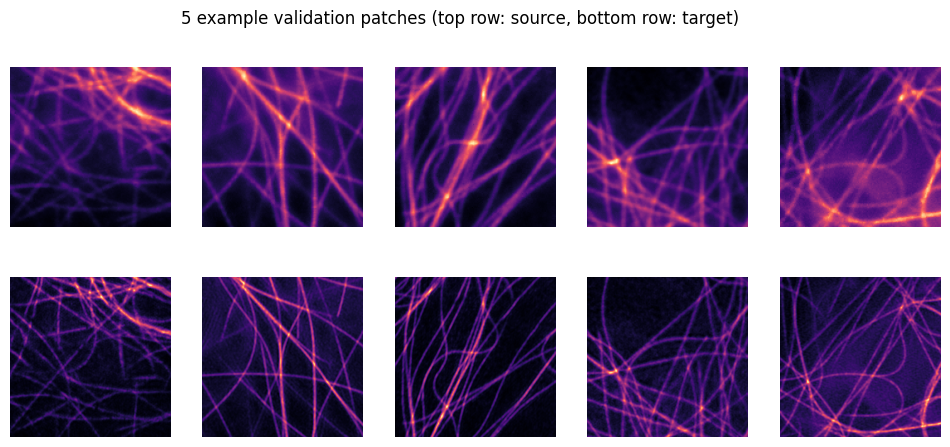

In [5]:
plt.figure(figsize=(12,5))
plot_some(tf.transpose(X_val[:5], perm=[0, 3, 1, 2]),Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)')

In [6]:
init_lr = 1e-4
batch_size = 3
epochs = 10
beta_1=0.9
beta_2=0.999
scale_gt = 2.0

total_data,  height, width, channels= X.shape

In [7]:
Trainingmodel = DFCAN((height, width, channels), scale=scale_gt)
optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
Trainingmodel.compile(loss=mse_ssim, optimizer=optimizer)
Trainingmodel.summary()

tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
lrate = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1)
hrate = callbacks.History()


(None, 128, 128, 9)


Tensor("Placeholder:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 9)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         5248      ['input_1[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['lambda[0][0]']              
                      

## Training
Training the model will likely take some time. We recommend to monitor the progress with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard), which allows you to inspect the losses during training.

You can start TensorBoard from the current working directory with `tensorboard --logdir=.` Then connect to http://localhost:6006/ with your browser.

In [8]:
history = Trainingmodel.fit(X, Y, batch_size=batch_size,
                               epochs=epochs, validation_data=(X_val, Y_val), shuffle=True,
                               callbacks=[lrate, hrate, tensorboard_callback])

Epoch 1/10
Tensor("model/lambda_81/mul_1:0", shape=(3, 128, 128, 256), dtype=float32),2.0
Tensor("model/lambda_81/mul_1:0", shape=(3, 128, 128, 256), dtype=float32),2.0
165/165 [==============================] - 1299s 8s/step - loss: 0.0940 - val_loss: 0.0495 - lr: 1.0000e-04
Epoch 2/10
165/165 [==============================] - 2263s 14s/step - loss: 0.0282 - val_loss: 0.0316 - lr: 1.0000e-04
Epoch 3/10
165/165 [==============================] - 2183s 13s/step - loss: 0.0219 - val_loss: 0.0224 - lr: 1.0000e-04
Epoch 4/10
165/165 [==============================] - 1607s 10s/step - loss: 0.0184 - val_loss: 0.0190 - lr: 1.0000e-04
Epoch 5/10
165/165 [==============================] - 1601s 10s/step - loss: 0.0176 - val_loss: 0.0201 - lr: 1.0000e-04
Epoch 6/10
153/165 [==========================>...] - ETA: 2:22 - loss: 0.0162

['loss', 'lr', 'val_loss']


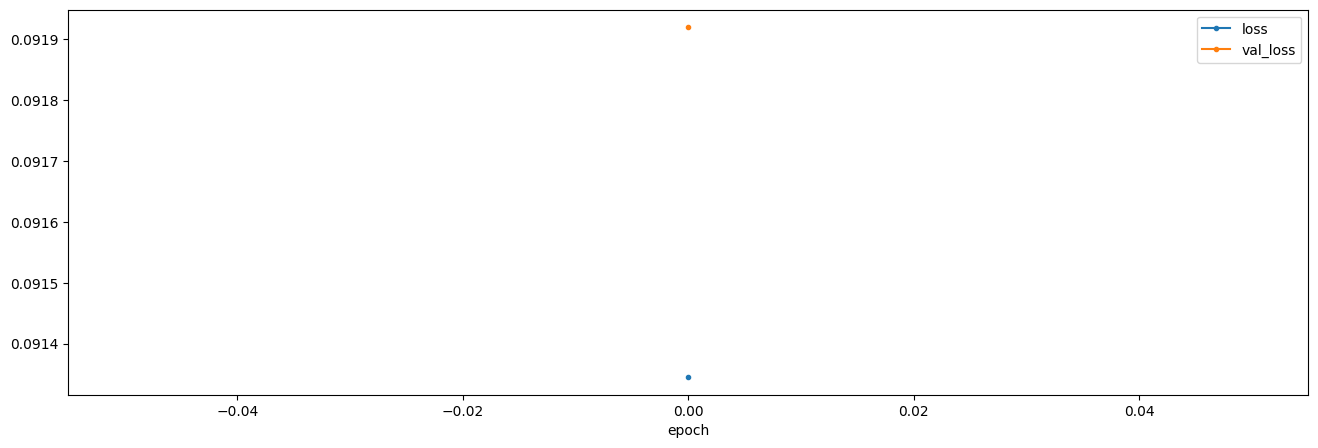

In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

1/1 [==============================] - 2s 2s/step


Text(0.5, 0.98, '5 example validation patches\ntop row: input (source),  middle row: target (ground truth),  bottom row: predicted from source')

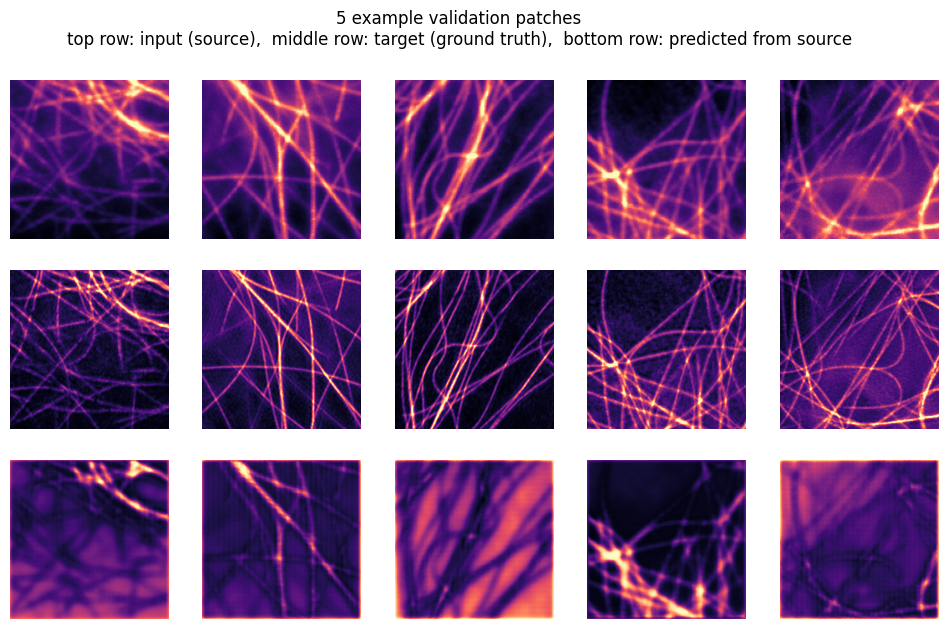

In [ ]:
plt.figure(figsize=(12,7))
_P = Trainingmodel.predict(X_val[:5])

plot_some(tf.transpose(X_val[:5], perm=[0, 3, 1, 2]),Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source')

In [ ]:
Trainingmodel.save(root_dir)

Tensor("model_4/lambda_413/mul_1:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
Tensor("inputs:0", shape=(None, 128, 128, 256), dtype=float32),2.0
INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/assets


INFO:tensorflow:Assets written to: /Users/vkapoor/Downloads/Microtubules/assets
